# Background

This assignment is on the temporal response function (TRF) framework for EEG analysis.

The following sources may be helpful for this assignment:
- Eelbrain [examples on TRFs](https://eelbrain.readthedocs.io/en/latest/auto_examples/#temporal-response-functions), in particular [TRF for Alice EEG Dataset](https://eelbrain.readthedocs.io/en/latest/auto_examples/temporal-response-functions/alice-trf.html)
- Paper describing more background: https://elifesciences.org/articles/85012


## General instructions
Same procedural instructions as for A1/2.

In addition: 

This assignment is in the form of questions about the data. 
For each question, decide on an approach to answer it at the group level. 
Generally, repeat the same analysis steps for each subject, 
collect relevant outcome variable(s) for each subject,
and then use appropriate test statistics that answers the question 
(e.g., a related-measures *t*-test).

Basic statistics functions from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) should be sufficient
(alongside `matplotlib` visualization).
However, you are also allowed to use functions from `pandas`, `seaborn`, `mne`, and `eelbrain` if those are helpful.

Make sure to formulate your answer to the initial question, and make it clear how the data you present supports you answer.

Document reasoning for parameter choices.

## Setup
- Use the environment defined in `A3-environment.yml`.
  - Check the file for instructions on how to create the environment from the file
- Download the Alice dataset.
  - The steps are outlined in the repository's README file (https://github.com/Eelbrain/Alice). In the README, under **Setup**, follow **Download this repository** and **Download the Alice dataset** (you don't need to follow **Create the Python environment** because we are using the `4CN3-A3` environment created in the previuos step)

### Loading the Downloaded Data

In [54]:
from pathlib import Path

import numpy
import eelbrain
import mne

# Define some paths that will be used throughout
DATA_ROOT = Path("~").expanduser() / 'Data' / 'Alice'
STIMULUS_DIR = DATA_ROOT / 'stimuli'
EEG_DIR = DATA_ROOT / 'eeg'

### Filtering the Data, Generating Acoustic Envelopes & Extracting the Predictor from the Stimulus

In [70]:

def preprocess_data(subject_id):

    # Load one subject's raw EEG file
    SUBJECT, ROI = subject_id, ['49', '50', '10', '11']

    raw = mne.io.read_raw(EEG_DIR / SUBJECT / f'{SUBJECT}_alice-raw.fif', preload=True)

    # Filter the raw data to the desired band
    LOW_FREQUENCY = 0.5
    HIGH_FREQUENCY = 20
    raw.filter(LOW_FREQUENCY, HIGH_FREQUENCY, n_jobs=1)
    # Interpolate bad channels
    # This is not strictly necessary for a single subject. 
    # However, when processing multiple subjects, it will allow comparing results across all sensors.
    raw.interpolate_bads()
    # Load the events embedded in the raw file as eelbrain.Dataset, a type of object that represents a data-table
    events = eelbrain.load.mne.events(raw)

    # Generate the acoustic envelope for all trials in this dataset
    envelopes = []
    for stimulus_id in events['event']:
        wav = eelbrain.load.wav(STIMULUS_DIR / f'{stimulus_id}.wav')
        envelope = wav.envelope()
        envelope = eelbrain.filter_data(envelope, LOW_FREQUENCY, HIGH_FREQUENCY, pad='reflect')
        envelope = eelbrain.resample(envelope, 100)
        envelopes.append(envelope)
    # Add the envelopes to the events table
    events['envelope'] = envelopes
    # Add a second predictor corresponding to acoustic onsets - beginning of sound (rapid increase in amplitude from zero)
    events['onsets'] = [envelope.diff('time').clip(0) for envelope in envelopes]

    # Extract the stimulus duration (in seconds) from the envelopes
    events['duration'] = eelbrain.Var([envelope.time.tstop for envelope in events['envelope']])

    # extract EEG data corresponding exactly to the timing of the envelopes
    events['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=5, connectivity='auto')


    # Get time series for EEG and acoustic onsets
    eeg = eelbrain.concatenate(events['eeg']).mean(sensor=ROI)
    onsets = eelbrain.concatenate(events['onsets'])
    return envelopes, onsets, eeg, events

# Decoding (Backward Model)

## 1. 

Question: *At what latencies does the cortical EEG response encode information about the acoustic envlope?*

Use cross-validation to fit decoders that can reconstruct the acoustic envelope from the EEG response.
Use linear decoders as discussed in class:
$\hat{s}_t = \sum_{ch} \sum_{\tau} h_{ch,\tau} r_{ch,t+\tau}$

Test the reconstruction accuracy on held-out test data.

By restricting the decoder to use EEG in a narrow latency window (i.e., by restricting the range of values used for $\tau$),
you can determine how much information the brain response contains in that latency range about the stimulus envelope.
For example, a decoder that only uses EEG data points lagging the stimulus by 175-225 ms
($\tau$ between 175 and 225 ms)
can tell you how much information about the stimulus is contained in the EEG response in the latency 175-225 ms.

Create a plot that shows decoding performance as a function of latency of the time lags 
(always using the same number of EEG data points, but varying the latencies used).
Use 6 different time ranges to cover the broad range between 0 and 600 ms relative to the stimulus.
Include some measure of confidence, like standard errors.
Evaluate which latency ranges lead to above chance decoding.

To speed up training for this assignment you can set `delta=0.05`. 
Note that, for a real experiment, we would be trading some accuracy for time.

### Group Level Approach:
We want to know what time points in our EEG data encode useful information about the stimulus. In other words, we want to know how probable it is that the EEG data within some time range are actually correlated with the acoustic envelope as opposed to it being mere chance that a correlation was detected. 

***Our hypothesis***: For some time range, there is a meaningful (above chance) correlation between the EEG signal and the acoustic envelope for a given trial. 

***Thus our null hypothesis***: There is no correlation between the two signals for a given trial, i.e across a population, the correlations are distributed around 0. 
### T-test:
Since we are working with a population of subjects, we can use t-test to evaluate the mean of the correlations for a single latency window. From that, we can obtain a p-value, which will give us the probability of the EEG data in that latency window being correlated with the stimulus if the null hypothesis were true (i.e. it was just chance that we got a correlation). We will assume that probabilities above 5% (p=0.05) are statistically significant. 

We can break down the 0-600ms window into non-overlapping intervals of length 100ms. It's important that they are non-overlapping because the computed correlations to be independent of each other, avoiding cumulative effects and specifying the contributions of the independent time points in the output. 
- for each latency: 
    - for each participant:
        - fit decoder on first n-1 trials 
        - predict on last trial (n) and get correlation 
    - get mean and standard error of the correlations across participants 
    - run t-test for the correlations across population, with the null hypothesis of p=0
- compare p-values of the latencies

In [325]:
# iterate over all the subjects and extract their events data
subject_events = []
for subject in Path(EEG_DIR).iterdir():
    envelopes, onsets, eeg, events = preprocess_data(subject.name)
    subject_events.append(events)

/var/folders/nc/99f_45_901x0qhcldskbqy880000gn/T/ipykernel_18201/135821323.py:15: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


In [321]:
import matplotlib.pyplot as plt
from scipy import stats

# Init some storage for values we want 
latency_windows, mean_correlations, sem, t_tests, p_values = [], [], [], [], []
t_lag = 0

# Iterate over time ranges 
for _ in range(6):
    correlations = []
    # Define current latency window
    tstart, tstop =  t_lag, t_lag+0.1

    # iterate over subjects
    for subject_data in subject_events:
        # Train decoder 
        decoder = eelbrain.boosting(y='envelope', # signal to predict, for decoder it is the stimulus envelope
                                    x='eeg', # signal to use to predict, for decoder it is the brain data 
                                    tstart=tstart, 
                                    tstop=tstop, # increment by 100ms 
                                    data=subject_data[:-1], # train on n-1 trials 
                                    partitions=5, # for K-folds cross val, K=5
                                    delta=0.05,
                                    test=True # set true for cross validation
        )
        # Get last trial's EEG signal & normalize 
        eeg = subject_data[-1, 'eeg'] / decoder.x_scale

        # Predict the envelope by convolving the decoder with the EEG & normalize 
        pred_env = eelbrain.convolve(decoder.h, eeg, name='predicted envelope') / decoder.y_scale

        # Extract the true envelope from the dataset
        true_env = subject_data[-1, 'envelope']

        # Compute and store correlation between the two values for this subject
        correlations.append(eelbrain.correlation_coefficient(true_env, pred_env))
    
    # Remove nans from correlations 
    correlations = [r for r in correlations if ~numpy.isnan(r)]

    # Compute mean and standard error of the population's correlations for this latency window 
    mean_correlations.append(numpy.mean(correlations)) 
    sem.append(numpy.std(correlations) / numpy.sqrt(len(events)))
    
    # Run t-test on the correlations for this window
    t_test, p_value = stats.ttest_1samp(correlations, popmean=0)
    t_tests.append(t_test)
    p_values.append(p_value)

    latency_windows.append(tstop)

    print(f"Trained decoder on data points {tstart:.3f}-{tstop:.3f}s lagging the stimulus with mean correlation of {mean_correlations[-1]}")
    
    # Update for next decoder latency window 
    t_lag+=0.100

    

Trained decoder on data points 0.000-0.100s lagging the stimulus with mean correlation of 0.11918207085840396
Trained decoder on data points 0.100-0.200s lagging the stimulus with mean correlation of 0.09362893807320327
Trained decoder on data points 0.200-0.300s lagging the stimulus with mean correlation of 0.05788711422836901
Trained decoder on data points 0.300-0.400s lagging the stimulus with mean correlation of 0.041602422755265184
Trained decoder on data points 0.400-0.500s lagging the stimulus with mean correlation of 0.020723264145693705
Trained decoder on data points 0.500-0.600s lagging the stimulus with mean correlation of 0.01321046874454958


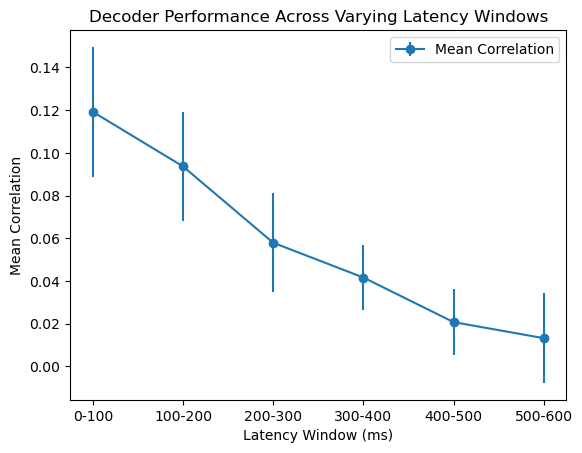

Latency window: 0-100ms
t-statistic: 8.3834
p-value: 1.404e-09
**Significant**

Latency window: 100-200ms
t-statistic: 7.7675
p-value: 9.175e-09
**Significant**

Latency window: 200-300ms
t-statistic: 5.3542
p-value: 7.089e-06
**Significant**

Latency window: 300-400ms
t-statistic: 5.8176
p-value: 2.064e-06
**Significant**

Latency window: 400-500ms
t-statistic: 2.8315
p-value: 8.066e-03
**Significant**

Latency window: 500-600ms
t-statistic: 1.3476
p-value: 1.873e-01
**Not significant**



In [322]:
# Plot performance (mean correlation) across latencies with standard error bars 
latency_windows = ["0-100", "100-200", "200-300", "300-400", "400-500", "500-600"]
# Add in error bars 
plt.errorbar(latency_windows, mean_correlations, yerr=sem, fmt='o-', label='Mean Correlation')
plt.title('Decoder Performance Across Varying Latency Windows')
plt.xlabel('Latency Window (ms)')
plt.ylabel('Mean Correlation')
plt.legend()
plt.show()

# Print numeric results to analyze to p-values
for latency, t_stat, p_value in zip(latency_windows, t_tests, p_values):
    print(f"Latency window: {latency}ms")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.3e}")
    if p_value < 0.05: print("**Significant**\n")
    else: print("**Not significant**\n")


### Conclusion 
From the above analysis, we see that EEG data points between 0-500ms produce statistically significant correlation in the decoder's performance accuracy. 

We also see that the most significant data points signals lie in the 0-100ms latency window relative to the stimulus, and that there is a gradual decline as the window gets temporally further from the onset of the stimulus. 

To conclude, the latency window from 0-500ms relative to the stimulus contains brain signals that give us information about the stimulus. Depending on our research goals, we could just train on 0-100ms windows to reduce training time/cost, however, the data in the 100-500ms still says something meaningful about the acoustic signal, therefore for the sake of completeness, we will say that the 0-500ms window encodes data from our acoustic envelope. 

## 2. 

Question: *How much data do you need to distinguish between 2 trials?*

Choose parameters for an optimal decoder based on your observations above.

For each participant, use the first n-2 trials to fit a decoder. 
Then, use the decoder to classify trial *n* and trial *n-1* as trial *n* vs trial *n-1*.
For example, a simple approach for classifying trial *n* would be to compare
$r(\hat{env_n}, env_n)$ with $r(\hat{env_n}, env_{n-1})$,
where *r* is the Pearson correlation, 
$env_n$ is the actual envelope of trial *n*,
and $\hat{env_n}$ is the envelope reconstructed from trial *n*.

Determine how the length of the test data (trials *n* and *n-1*) affects the decoder's ability to distinguish between the two trials.
For example, if you're given only the first 5 s of each trial, your classification will presumably perform worse than if you are given the first 120 s.
Use at least 5 different lengths between 5 s and full trial length.

### Group Level Approach:
Similar to above, we can vary the length of test data during training to determine at the effect of the the length of the data on the uniqueness of the trials. Since the performance metric being observed here is binary classification, we can say that an above 50% accuracy implies the test data did contribute to the distinction. 

***Our hypothesis***: Depending on the time length, there is a significant (above chance) distinction between 2 trials. 

***Thus our null hypothesis***: The decorder has a 50-50 chance of classifying the sample correctly due to mere chance. 
### T-test:
We can again use the t-test on our population data. 
- for each time length: 
    - for each participant:
        - fit decoder on first n-2 trials 
        - predict on last trial (n-1) and get correlation(true_1, predict_1) (r1)
        - get correlation(true_2, predict_1) (r2)
        - if r1 > r2 mark as accurate (100%), else mark as incorrect (0%)
    - run t-test for the accuracies across population, with the null hypothesis of p=50
- compare p-values of the time intervals

In [326]:
import matplotlib.pyplot as plt
from scipy import stats

# Init some storage for values we want 
mean_accuracies, sem, t_tests, p_values = [], [], [], []
# for the sake of simplicity and consistency across trials, predefine test lengths
test_lengths = [5.0, 15.0, 25.0, 35.0, min([min(events['duration']) for events in subject_events])]

# Iterate over all lengths
for trial_len in test_lengths[::-1]: # since subject_data is updated in place, we will start backwards to preform the decreasing trial length
    accuracies = []
    # Iterate over subjects
    for subject_data in subject_events:
        # Update duration of eeg and envelopes to trial_len
        subject_data['eeg'] = eelbrain.load.mne.epochs(subject_data, 0, tmax=trial_len-0.01, decim=5, connectivity='auto')
        subject_data['envelope'] = [data[:trial_len] for data in subject_data['envelope']]
        
        # Double check shape 
        print(subject_data['eeg'][0].shape)
        print(subject_data['envelope'][0].shape)

        decoder = eelbrain.boosting(y='envelope', # signal to predict, for decoder it is the stimulus envelope
                                    x='eeg', # signal to use to predict, for decoder it is the brain data 
                                    tstart=0, 
                                    tstop=0.5, # set trial length
                                    data=subject_data[:-2], # train on n-2 trials 
                                    partitions=5, 
                                    delta=0.05,
        )

        # Get last trial's EEG signal & normalize 
        eeg_n = subject_data[-1, 'eeg'] / decoder.x_scale

        # Predict the envelope by convolving the decoder with the EEG & normalize 
        pred_env_n = eelbrain.convolve(decoder.h, eeg_n, name='predicted envelope') / decoder.y_scale

        # Get second last trial
        eeg_n_1 = subject_data[-2, 'eeg'] / decoder.x_scale

        # Extract the true envelope for last 2 trials
        true_env_n = subject_data[-1, 'envelope']
        true_env_n_1 = subject_data[-2, 'envelope']

        # Get pearson correlations for the true classification 
        r1 = eelbrain.correlation_coefficient(true_env_n, pred_env_n)

        # Get pearson correlations for the false classification 
        r2 = eelbrain.correlation_coefficient(true_env_n_1, pred_env_n)
        print(f"r1: {r1}")
        print(f"r2: {r2}")
        
        if r1 and r2: # skip nans for mean and t-test calculations 
            accuracies.append(100 if r1 > r2 else 0)

    # Compute mean and standard error of the population's accuracies for this latency window 
    mean_accuracies.append(numpy.mean(accuracies)) 
    sem.append(numpy.std(mean_accuracies) / numpy.sqrt(len(events)))
    
    # Run t-test on the correlations for this window, with null hypothesis of 50% chance 
    t_test, p_value = stats.ttest_1samp(accuracies, popmean=50)
    t_tests.append(t_test)
    p_values.append(p_value)
    
    print(f"Trained decoder on trial length {trial_len}s with mean accuracy of {mean_accuracies[-1]}")



(61, 4698)
(4698,)
r1: 0.11630766320529294
r2: 0.03810418877116473
(61, 4698)
(4698,)
r1: 0.05978737325477374
r2: 0.012146187642466328
(61, 4698)
(4698,)
r1: 0.024707504638643043
r2: -0.008430021633100027
(61, 4698)
(4698,)
r1: 0.08669564577053705
r2: -0.0012418769383364862
(61, 4698)
(4698,)
r1: 0.16141052128706784
r2: 0.04359403431406629
(61, 4698)
(4698,)
r1: 0.19042014925782666
r2: 0.027056799782286933
(61, 4698)
(4698,)
r1: nan
r2: nan
(61, 4698)
(4698,)
r1: 0.14616512885364533
r2: -0.04090693911424401
(61, 4698)
(4698,)
r1: 0.06721466675228806
r2: 0.05107726481484106
(61, 4698)
(4698,)
r1: 0.024761935014762555
r2: 0.053094855727461795
(61, 4698)
(4698,)
r1: 0.18800844992105278
r2: 0.024324703936516572
(61, 4698)
(4698,)
r1: 0.05134581303723712
r2: 0.0248882355977834
(61, 4698)
(4698,)
r1: 0.14713638316733338
r2: -0.027717875601143045
(61, 4698)
(4698,)
r1: 0.02082624304189182
r2: -0.009546924612592858
(61, 4698)
(4698,)
r1: 0.11920816973929384
r2: -0.03063962945190297
(61, 4698)


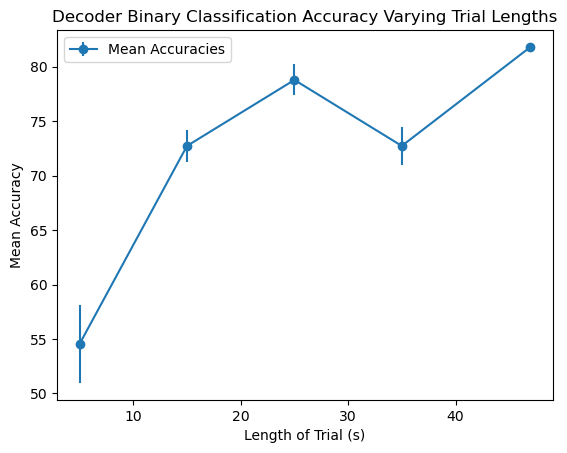

Trial Length: 5.0s
t-statistic: 0.5164
p-value: 6.091e-01
**Not significant**

Trial Length: 15.0s
t-statistic: 2.8868
p-value: 6.920e-03
**Significant**

Trial Length: 25.0s
t-statistic: 3.9835
p-value: 3.669e-04
**Significant**

Trial Length: 35.0s
t-statistic: 2.8868
p-value: 6.920e-03
**Significant**

Trial Length: 46.980000000000004s
t-statistic: 4.6667
p-value: 5.222e-05
**Significant**



In [328]:
# # Plot performance (mean accuracies) across time intervals with standard error bars 
plt.errorbar(test_lengths, mean_accuracies[::-1], yerr=sem[::-1], fmt='o-', label='Mean Accuracies')
plt.title('Decoder Binary Classification Accuracy Varying Trial Lengths')
plt.xlabel('Length of Trial (s)')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.show()

# Print numeric results to analyze to p-values
for trial_length, t_stat, p_value in zip(test_lengths, t_tests[::-1], p_values[::-1]):
    print(f"Trial Length: {trial_length}s")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.3e}")
    if p_value < 0.05: print("**Significant**\n")
    else: print("**Not significant**\n")


#### Conclusion
From the above results, we see that as expected, increasing the length of the trial during training leads to higher accuracies. We see a mostly linear increase in accuracy and  This is likely due to the lower relative SNR. The longer trials can capture higher order cortical responses relating to the distinct auditory information for the specific trial. For instance, if we think about capturing response to random gibrish vs meaningful auditory signals, where the resulting response reflects a combined affect of the previous stimulus, it makes sense that longer trials would allow us to distinguish auditory responses more accurately. 